In [29]:
import numpy as np
import matplotlib.pyplot as plt
from colorsys import hls_to_rgb
import pyMMF


def colorize(z, theme='dark', saturation=1., beta=1.4, transparent=False, alpha=1.):
    r = np.abs(z)
    r /= np.max(np.abs(r))
    arg = np.angle(z)

    h = (arg + np.pi) / (2 * np.pi) + 0.5
    l = 1. / (1. + r ** beta) if theme == 'white' else 1. - 1. / (1. + r ** beta)
    s = saturation

    c = np.vectorize(hls_to_rgb)(h, l, s)  # --> tuple
    c = np.array(c)  # -->  array of (3,n,m) shape, but need (n,m,3)
    c = c.swapaxes(0, 2)
    if transparent:
        a = 1. - np.sum(c ** 2, axis=-1) / 3
        alpha_channel = a[..., None] ** alpha
        return np.concatenate([c, alpha_channel], axis=-1)
    else:
        return c


def complex_correlation(Y1, Y2):
    Y1 = Y1 - Y1.mean()
    Y2 = Y2 - Y2.mean()
    return np.abs(np.sum(Y1.ravel() * Y2.ravel().conj())) \
        / np.sqrt(np.sum(np.abs(Y1.ravel()) ** 2) * np.sum(np.abs(Y2.ravel()) ** 2))


tr = lambda A, B: np.trace(np.abs(A @ B.transpose().conjugate()) ** 2)

fidelity = lambda A, B: tr(A, B) / (np.sqrt(tr(A, A) * tr(B, B)))

## Parameters

In [30]:
NA = 0.085
radius = 23  # in microns
areaSize = 2.4 * radius  # calculate the field on an area larger than the diameter of the fiber
n_points_modes = 128  # resolution of the window
n1 = 1.45  # index of refraction at r=0 (maximum)
wl = 0.633  # wavelength in microns
curvature = None
k0 = 2. * np.pi / wl

r_max = 3.2 * radius
npoints_search = 2 ** 8
dh = 2 * radius / npoints_search

## Simulate a graded index fiber

In [43]:
def get_modes(npoints):
    profile = pyMMF.IndexProfile(npoints=npoints, areaSize=areaSize)
    profile.initStepIndex(n1=n1, a=radius, NA=NA)
    # profile.initParabolicGRIN(n1=n1, a=radius, NA=NA)

    solver = pyMMF.propagationModeSolver()
    solver.setIndexProfile(profile)
    solver.setWL(wl)
    modes = solver.solve(mode='radial',
                         curvature=None,
                         r_max=r_max,  # max radius to calculate (and first try for large radial boundary condition)
                         dh=dh,  # radial resolution during the computation
                         min_radius_bc=1.5,  # min large radial boundary condition
                         change_bc_radius_step=0.95,  #change of the large radial boundary condition if fails
                         N_beta_coarse=1000,  # number of steps of the initial coarse scan
                         degenerate_mode='exp',
                         )
    return modes


modes = get_modes(n_points_modes)

2024-07-31 09:26:20,679 - pyMMF.core [DEBUG  ]  Debug mode ON.
2024-07-31 09:26:20,696 - pyMMF.solv [INFO   ]  Found 6 radial mode(s) for m=0
2024-07-31 09:26:20,730 - pyMMF.solv [INFO   ]  Found 6 radial mode(s) for m=1
2024-07-31 09:26:20,770 - pyMMF.solv [INFO   ]  Found 5 radial mode(s) for m=2
2024-07-31 09:26:20,797 - pyMMF.solv [INFO   ]  Found 5 radial mode(s) for m=3
2024-07-31 09:26:20,829 - pyMMF.solv [INFO   ]  Found 5 radial mode(s) for m=4
2024-07-31 09:26:20,864 - pyMMF.solv [INFO   ]  Found 4 radial mode(s) for m=5


dh=0.1796875


2024-07-31 09:26:20,897 - pyMMF.solv [INFO   ]  Found 4 radial mode(s) for m=6
2024-07-31 09:26:20,938 - pyMMF.solv [INFO   ]  Found 3 radial mode(s) for m=7
2024-07-31 09:26:20,963 - pyMMF.solv [INFO   ]  Found 3 radial mode(s) for m=8
2024-07-31 09:26:20,979 - pyMMF.solv [INFO   ]  Found 2 radial mode(s) for m=9
2024-07-31 09:26:21,012 - pyMMF.solv [INFO   ]  Found 2 radial mode(s) for m=10
2024-07-31 09:26:21,029 - pyMMF.solv [INFO   ]  Found 2 radial mode(s) for m=11
2024-07-31 09:26:21,061 - pyMMF.solv [INFO   ]  Found 1 radial mode(s) for m=12
2024-07-31 09:26:21,078 - pyMMF.solv [INFO   ]  Found 1 radial mode(s) for m=13
2024-07-31 09:26:21,099 - pyMMF.solv [INFO   ]  Found 1 radial mode(s) for m=14
2024-07-31 09:26:21,113 - pyMMF.solv [INFO   ]  Found 1 radial mode(s) for m=15
2024-07-31 09:26:21,129 - pyMMF.solv [INFO   ]  Found 0 radial mode(s) for m=16
2024-07-31 09:26:21,129 - pyMMF.solv [INFO   ]  Solver found 96 modes is 0.45 seconds.
2024-07-31 09:26:21,129 - pyMMF.core 

## Show some modes

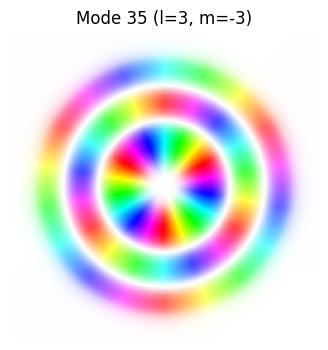

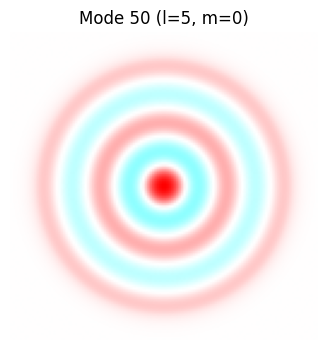

In [44]:
i_modes = [35, 50]

M0 = modes.getModeMatrix()

for i in i_modes:
    Mi = M0[..., i]
    profile = Mi.reshape([n_points_modes] * 2)
    plt.figure(figsize=(4, 4))
    plt.imshow(colorize(profile, 'white'))
    # plt.imshow(np.abs((profile)**2))
    # plt.colorbar()
    plt.axis('off')
    plt.title(f'Mode {i} (l={modes.l[i]}, m={modes.m[i]})')
    # save figure
    # plt.savefig(f'mode_{i}.svg')


## save data

96

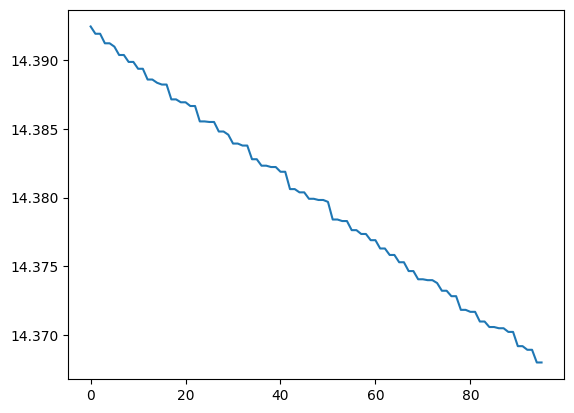

In [54]:
# no degenerate groups with SI fibers
i = 10
M0 = modes.getModeMatrix()
Mi = M0[..., i]
profile = Mi.reshape([n_points_modes] * 2)
profile.shape
np.array(modes.betas).shape
groups = modes.getNearDegenerate(tol=3e-4, sort=True)
len(groups)
plt.plot(modes.betas)
modes.number

In [55]:
groups

[[0],
 [1, 2],
 [3, 4, 5],
 [6, 7],
 [8, 9],
 [10, 11],
 [12, 13, 14],
 [15, 16],
 [17, 18, 19, 20],
 [21, 22],
 [23, 24, 25, 26],
 [27, 28, 29],
 [30, 31, 32, 33],
 [34, 35],
 [36, 37, 38, 39],
 [40, 41],
 [42, 43, 44, 45],
 [46, 47, 48, 49, 50],
 [51, 52, 53, 54],
 [55, 56, 57, 58],
 [59, 60],
 [61, 62],
 [63, 64],
 [65, 66],
 [67, 68],
 [69, 70, 71, 72, 73],
 [74, 75],
 [76, 77],
 [78, 79, 80, 81],
 [82, 83],
 [84, 85, 86, 87],
 [88, 89],
 [90, 91, 92, 93],
 [94, 95]]

In [56]:
import datetime
timestamp = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

betas = modes.betas
mode_profiles = modes.profiles[1]
index_profile = modes.indexProfile.n
X = modes.indexProfile.X
Y = modes.indexProfile.Y
outfile = rf"C:\temp\TMs\{timestamp}_modes.npz"


def create_block_diagonal_matrix(groups):
    max_value = max(max(group) for group in groups)
    matrix_size = max_value + 1
    matrix = np.zeros((matrix_size, matrix_size), dtype=bool)

    for group in groups:
        for i in group:
            for j in group:
                matrix[i, j] = True

    return matrix

groups = modes.getNearDegenerate(tol=1e-3, sort=True)


N_modes = 25
# N_modes = modes.number
np.savez(outfile,
         betas=modes.betas[:N_modes],
         profiles=modes.profiles[:N_modes],
         index_profile=modes.indexProfile.n,
         X=X,
         Y=Y,
         l=modes.l[:N_modes],
         m=modes.m[:N_modes],
         nmodes=N_modes,
         npoints=n_points_modes,
         mask_near_degenerate=create_block_diagonal_matrix(groups)[:N_modes, :N_modes]
         )

In [38]:
modes.number

45

[[0, 1, 2],
 [3, 4, 5, 6, 7],
 [8, 9, 10, 11],
 [12, 13, 14, 15, 16],
 [17, 18, 19, 20, 21, 22],
 [23, 24, 25, 26, 27, 28, 29],
 [30, 31, 32, 33],
 [34, 35, 36, 37, 38, 39, 40, 41],
 [42, 43, 44, 45, 46, 47, 48, 49, 50],
 [51, 52, 53, 54, 55, 56],
 [57, 58, 59, 60],
 [61, 62, 63, 64, 65, 66],
 [67, 68, 69, 70, 71, 72, 73],
 [74, 75, 76, 77],
 [78, 79, 80, 81, 82, 83],
 [84, 85, 86, 87, 88, 89],
 [90, 91, 92, 93],
 [94, 95]]

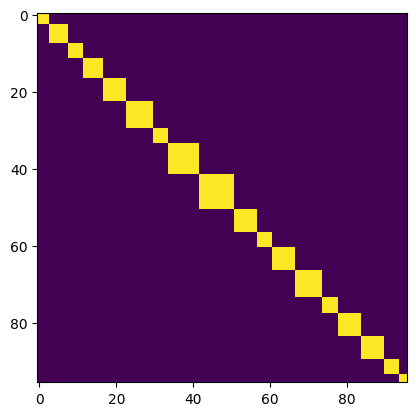

In [57]:
plt.imshow(create_block_diagonal_matrix(groups))
groups